In [ ]:
from pandas import DataFrame,read_csv
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
import os
from prettytable import PrettyTable
import gc
drive.mount('/content/drive')

Mounted at /content/drive


# 1

The same procedure as the first assignment. The columns are created , we iterate through each file in order to find and drop the columns that are not desirable.I create dfs from the reviews of each month and then merge them and write them to a .csv file.

In [ ]:
columns = ['id' , 'comments']

june_df=pd.DataFrame()
Location = r'/content/drive/My Drive/path/to/june_data.csv'
june_df=pd.read_csv(Location,low_memory=False)

for x in june_df:
    if x not in columns:
        del june_df[x]
#add month column
june_df['Month'] = 'June'

september_df=pd.DataFrame()
Location = r'/content/drive/My Drive/path/to/september_data.csv'
september_df=pd.read_csv(Location,low_memory=False)

for x in september_df:
    if x not in columns:
        del september_df[x]
#add month column
september_df['Month'] = 'September'

march_df=pd.DataFrame()
Location = r'/content/drive/My Drive/path/to/march_data.csv'
march_df=pd.read_csv(Location, low_memory=False)

for x in march_df:
    if x not in columns:
        del march_df[x]
#add month column
march_df['Month'] = 'March'

df = pd.concat([june_df,september_df,march_df])
count = 0
for x in df:
    count +=1
    print(x)
print(count)

df.to_csv('/content/drive/My Drive/path/to/all_data.csv' , index=False)
del df , june_df, september_df, march_df
gc.collect()

In [ ]:
!pip install langdetect
!pip install afinn
from langdetect import detect
import seaborn as sns
import re
import spacy
import nltk
from afinn import Afinn
from concurrent.futures import ProcessPoolExecutor, as_completed
import gc
from joblib import Parallel, delayed
nltk.download('punkt')
from transformers import pipeline

The next two cells are similar to what i've used for the recommendation system in the first assignment.Functions to remove stopwords with the help of spacy , remove emojis and html.Sample 3000 rows from the DataFrame , creating a new one with the specified columns.ID is index in random_df.Add a column 'language' to find the non-english strings and drop the corresponding rows. Lowercase everything and drop 'language' column. The same code is used for both years by adjusting the location from my drive.

In [ ]:
df=pd.DataFrame()
Location = r'/content/drive/My Drive/path/to/all_data.csv'
df = pd.read_csv(Location , low_memory= False)

punctuation_pattern = r'[^\w\s]'
number_pattern = r'\b\d+\b'
nlp = spacy.load('en_core_web_sm')

# to remove stopwords
def remove_stopwords(text):
    doc = nlp(text)
    text_no_stopwords = ' '.join([token.text for token in doc if not token.is_stop])
    return text_no_stopwords
# to remove emojis
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
# remove punctuation marks , numbers and html
def remove_html_pun_num(text):
    text_no_num = re.sub(number_pattern, '', text)
    text_no_pun = re.sub(punctuation_pattern, '', text_no_num)
    return re.compile(r'<[^>]+>').sub('', text_no_pun)

def detect_en(text):
  try:
    return detect(text)
  except:
    return 'unknown'

In [ ]:
sample_df = df.sample(4500)
random_df = sample_df[['id' ,'comments']].copy()

random_df = random_df.fillna('')
random_df['comments'] = random_df['comments'].apply(remove_html_pun_num)
random_df['comments'] = random_df['comments'].apply(remove_emojis)
random_df['comments'] = random_df['comments'].apply(remove_stopwords)

lang_df = random_df['comments'].apply(detect_en)
random_df['language'] = lang_df

rows_to_drop = random_df[random_df['language'] != 'en']
random_df = random_df.drop(rows_to_drop.index)

random_df['comments'] = random_df['comments'].str.lower()
random_df = random_df.drop('language' , axis=1)

del sample_df
# num_rows = random_df.shape[0]
# print(num_rows)
# print(random_df)

I process the data by chunks. ProcessPoolExecutor is used for parallel execution.

In [ ]:
sentiment_analysis =pipeline("text-classification", model="j-hartmann/sentiment-roberta-large-english-3-classes", return_all_scores=True)
def analyze_sentiment(text):
    try:
        result_list = sentiment_analysis(text)
        if isinstance(result_list, list) and result_list:
# Extract the inner list of dictionaries
            result = result_list[0]
# choose result with highest score
            if isinstance(result, list) and result:
                top_score = max(result, key=lambda x: x['score'])['score']

                for item in result:
                    if item['score'] == top_score:
                        return item['label'], item['score']
            else:
                print(f"Unexpected result format inside the inner list: {result}")
                return None, None
        else:
            print(f"Unexpected result format: {result_list}")
            return None, None
    except Exception as e:
        print(f"Error analyzing sentiment: {e}")
        return None, None

def process_chunk(chunk):
    chunk['sentiment'], chunk['score'] = zip(*chunk['comments'].apply(analyze_sentiment))
    return chunk

def parallel_process(df, func, n_jobs=4, batch_size=100):
    results = []
    with ProcessPoolExecutor(max_workers=n_jobs) as executor:
        futures = []
        for i in range(0, len(df), batch_size):
            chunk = df.iloc[i:i + batch_size]
            futures.append(executor.submit(func, chunk))

        for future in as_completed(futures):
            try:
                result = future.result()
                results.append(result)
            except Exception as e:
                print(f"Error processing chunk: {e}")

    # Combine results of chunks
    final_df = pd.concat(results)
    gc.collect()
    return final_df

n_jobs = 4
batch_size = 100
try:
    result_df = parallel_process(random_df, process_chunk, n_jobs=n_jobs, batch_size=batch_size)

    pos = sum(result_df['sentiment'] == 'positive')
    neg = sum(result_df['sentiment'] == 'negative')
    neut = sum(result_df['sentiment'] == 'neutral')

    print(f'Pos = {pos / len(result_df)} and Neg = {neg / len(result_df)}')
    print(f'Pos = {pos} and Neg = {neg} and Neut = {neut}')

except Exception as e:
    print(f"Error during parallel processing: {e}")

In [ ]:
result_df.to_csv('/content/drive/My Drive/path/to/sample_data.csv' , index=False)

(3330, 4)
(3239, 4)


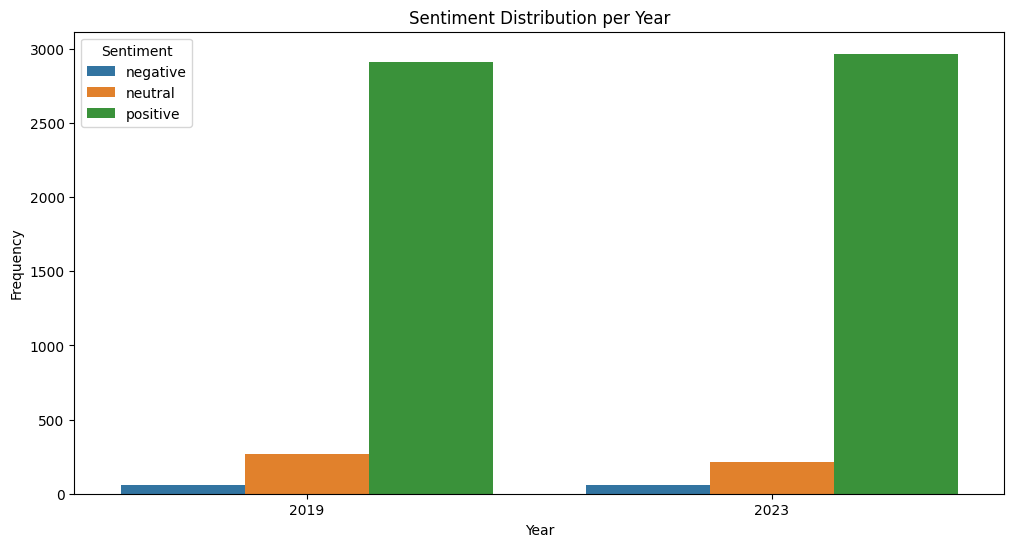

In [ ]:
res2019_df = pd.read_csv('/content/drive/My Drive/path/to/sample_data.csv' , low_memory= False , lineterminator='\n')
res2023_df = pd.read_csv('/content/drive/My Drive/path/to//sample_data.csv' , low_memory= False , lineterminator='\n')
# print(res2019_df.shape)
# print(res2023_df.shape)

#Making the  2 dfs same size by removing some postives
positive_rows = res2019_df[res2019_df['sentiment'] == 'positive']
rows_to_remove = positive_rows.head(91)
res2019_df_filtered = res2019_df.drop(rows_to_remove.index)

res2023_df['year'] = 2023
res2019_df_filtered['year'] = 2019
combined_df = pd.concat([res2019_df_filtered, res2023_df], axis=0)
grouped_df = combined_df.groupby(['year', 'sentiment']).size().reset_index(name='count')

# Plotting the bar plot for comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='count', hue='sentiment', data=grouped_df)
plt.title('Sentiment Distribution per Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(title='Sentiment')
plt.show()

# 2

Splitting the Data to tain and test so predictions can be made on sentiments.

3 different classifiers will be used :

KNN , Random Forest , SVM

Load 2023 csv file I created from the sentiment analysis of the previous question(the data are already processed). Define a function for tokenization and handling of unknown vocabulary .Split the data for both TF-IDF and Word Embeddings and finally generating some synthetic samples(negative and neutral) using SMOTE to balance the data.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from scipy.sparse import csr_matrix
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import gensim.downloader as api

In [ ]:
#2023
Location = r'/content/drive/My Drive/path/to/'
model_df = pd.read_csv(Location + 'sample_sent.csv' , low_memory= False , lineterminator='\n')

#Tokenize for we
wv = api.load('word2vec-google-news-300')
def comment_to_feature(comment , key_to_index):
  words = comment.lower().split()
  word_vectors = [wv[word] for word in words if word in key_to_index]

  if not word_vectors:  # Handle Out-of-Vocabulary (OOV) words
      word_vectors = [np.zeros(wv.vector_size)]  #
  feature_vector = np.mean(word_vectors, axis=0)
  return feature_vector

X_tf = model_df['comments'].tolist()
y = model_df['sentiment'].tolist()

#create word embeddings
X_we = model_df['comments'].apply(lambda comment: comment_to_feature(comment, wv.key_to_index)).tolist()

#split
X_train, X_test, y_train, y_test = train_test_split(X_tf, y, test_size=0.2, random_state=42)
X_train_we, X_test_we, y_train, y_test = train_test_split(X_we, y, test_size=0.2, random_state=42)

#create the tf-idf
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

#balancing data
#Regarding of which method is desired , comment the specific lines.The first to resamples are for tf-idf

smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(tfidf_matrix, y_train)
# X_resampled_test, y_resampled_test = smote.fit_resample(X_test_tfidf, y_train)

X_resampled, y_resampled = smote.fit_resample(X_train_we, y_train)
X_resampled_test, y_resampled_test = smote.fit_resample(X_test_we, y_test)


[==================================================] 100.0% 1662.8/1662.8MB downloaded


KNN using 10-fold Cross Validation

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
##Train
y_pred = cross_val_predict(knn, X_resampled, y_resampled, cv=kfold)

accuracy = accuracy_score(y_resampled, y_pred)
precision = precision_score(y_resampled, y_pred, average='macro')
recall = recall_score(y_resampled, y_pred, average='macro')
f1 = f1_score(y_resampled, y_pred, average='macro')

print("Training Set Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

#Test
y_pred = cross_val_predict(knn, X_resampled_test, y_resampled_test, cv=kfold)

accuracy = accuracy_score(y_resampled_test, y_pred)
precision = precision_score(y_resampled_test, y_pred, average='macro')
recall = recall_score(y_resampled_test, y_pred, average='macro')
f1 = f1_score(y_resampled_test, y_pred, average='macro')

print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Training Set Metrics:
Accuracy: 0.8927170868347339
Precision: 0.9127987372544095
Recall: 0.8927170868347339
F1-score: 0.8880294554609008

Test Set Metrics:
Accuracy: 0.8801817149346962
Precision: 0.9040195368217706
Recall: 0.8801817149346962
F1-score: 0.8737532207045963


SVM using 10-fold Cross Validation

In [ ]:
svm_classifier = svm.SVC(kernel='linear')
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
#Train
y_pred_train = cross_val_predict(svm_classifier, X_resampled, y_resampled, cv=kfold)

accuracy_train = accuracy_score(y_resampled, y_pred_train)
precision_train = precision_score(y_resampled, y_pred_train, average='macro')
recall_train = recall_score(y_resampled, y_pred_train, average='macro')
f1_train = f1_score(y_resampled, y_pred_train, average='macro')

print("Training Set Metrics:")
print(f"Accuracy: {accuracy_train}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1-score: {f1_train}")

#Test
y_pred = cross_val_predict(svm_classifier, X_resampled_test, y_resampled_test, cv=kfold)

accuracy = accuracy_score(y_resampled_test, y_pred)
precision = precision_score(y_resampled_test, y_pred, average='macro')
recall = recall_score(y_resampled_test, y_pred, average='macro')
f1 = f1_score(y_resampled_test, y_pred, average='macro')

print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Training Set Metrics:
Accuracy: 0.9592436974789916
Precision: 0.9610247560323626
Recall: 0.9592436974789916
F1-score: 0.9590294766921396

Test Set Metrics:
Accuracy: 0.9727427597955707
Precision: 0.9745004080399512
Recall: 0.9727427597955707
F1-score: 0.9726169483644135


Random Forest using 10-fold Cross Validation

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
#Train
y_pred = cross_val_predict(rf_classifier, X_resampled, y_resampled, cv=kfold)

accuracy = accuracy_score(y_resampled, y_pred)
precision = precision_score(y_resampled, y_pred, average='macro')
recall = recall_score(y_resampled, y_pred, average='macro')
f1 = f1_score(y_resampled, y_pred, average='macro')

print("Training Set Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

#Test
y_pred = cross_val_predict(rf_classifier, X_resampled_test, y_resampled_test, cv=kfold)

accuracy = accuracy_score(y_resampled_test, y_pred)
precision = precision_score(y_resampled_test, y_pred, average='macro')
recall = recall_score(y_resampled_test, y_pred, average='macro')
f1 = f1_score(y_resampled_test, y_pred, average='macro')

print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Training Set Metrics:
Accuracy: 0.9899159663865547
Precision: 0.9900227870940658
Recall: 0.9899159663865547
F1-score: 0.9899130854180527

Test Set Metrics:
Accuracy: 0.9937535491198183
Precision: 0.9938000696621386
Recall: 0.9937535491198183
F1-score: 0.993753327040224
